# Helpers

In [1]:
import numpy as np 
import scipy.sparse as sps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy 
import os
import datetime
import argparse
from IPython.display import clear_output

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')
from tqdm import tqdm

In [3]:
def create_laplacian_sparse(data, target_measure, epsilon, n_neighbors):

    num_features = data.shape[1]
    num_samples = data.shape[0]

    ### Create distance matrix
    neigh = NearestNeighbors(n_neighbors=n_neighbors, metric='sqeuclidean')
    neigh.fit(data)
    sqdists = neigh.kneighbors_graph(data, mode="distance") 
    print(f"Data type of squared distance matrix: {type(sqdists)}")

    ### Create Kernel
    K = sqdists.copy()
    K.data = np.exp(-K.data / (2*epsilon))
    K = 0.5*(K + K.T)
 
    kde = np.asarray(K.sum(axis=1)).ravel()
    #kde *=  (1.0/num_samples)*(2*np.pi*epsilon)**(-num_features/2) 
    
    # Check sparsity of kernel
    num_entries = K.shape[0]**2
    nonzeros_ratio = K.nnz / (num_entries)
    print(f"Ratio of nonzeros to zeros in kernel matrix: {nonzeros_ratio}")

    ### Create Graph Laplacian
    u = (target_measure**(0.5)) / kde
    U = sps.spdiags(u, 0, num_samples, num_samples) 
    W = U @ K @ U
    stationary = np.asarray(W.sum(axis=1)).ravel()
    inv_stationary = np.power(stationary, -1)
    P = sps.spdiags(inv_stationary, 0, num_samples, num_samples) @ W 
    L = (P - sps.eye(num_samples, num_samples))/epsilon

    return [stationary, K, L]

def create_laplacian_dense(data, target_measure, epsilon):
    num_features = data.shape[1]
    num_samples = data.shape[0]

    ### Create distance matrix
    sqdists = cdist(data, data, 'sqeuclidean') 
    
    ### Create Kernel
    K = np.exp(-sqdists / (2.0*epsilon))

    ### Create Graph Laplacian
    kde = K.sum(axis=1)
    u = (target_measure**(0.5)) / kde
    U = np.diag(u)
    W = U @ K @ U
    stationary = W.sum(axis=1)
    P = np.diag(stationary**(-1)) @ W 
    L = (P - np.eye(num_samples))/epsilon

    return [stationary, K, L]

def compute_spectrum_sparse(L, stationary, num_eigvecs):
    # Symmetrize the generator 
    num_samples = L.shape[0]
    Dinv_onehalf =  sps.spdiags(stationary**(-0.5), 0, num_samples, num_samples)
    D_onehalf =  sps.spdiags(stationary**(0.5), 0, num_samples, num_samples)
    Lsymm = D_onehalf @ L @ Dinv_onehalf

    # Compute eigvals, eigvecs 
    evals, evecs = sps.linalg.eigsh(Lsymm, k=num_eigvecs, which='SM')

    # Convert back to L^2 norm-1 eigvecs of L 
    evecs = (Dinv_onehalf) @ evecs
    evecs /= (np.sum(evecs**2, axis=0))**(0.5)
    
    idx = evals.argsort()[::-1][1:]     # Ignore first eigval / eigfunc
    evals = np.real(evals[idx])
    evecs = np.real(evecs[:, idx])
    dmap = np.dot(evecs, np.diag(np.sqrt(-1./evals)))
    return dmap, evecs, evals

def compute_spectrum_dense(L, stationary, num_eigvecs):
    # Symmetrize the generator 
    Dinv_onehalf =  np.diag(stationary**(-0.5))
    D_onehalf =  np.diag(stationary**(0.5))
    Lsymm = D_onehalf @ L @ Dinv_onehalf

    # Compute eigvals, eigvecs 
    evals, evecs = sps.linalg.eigsh(Lsymm, k=num_eigvecs, which='SM')

    # Convert back to L^2 norm-1 eigvecs of L 
    evecs = (Dinv_onehalf) @ evecs
    evecs /= (np.sum(evecs**2, axis=0))**(0.5)
    
    idx = evals.argsort()[::-1][1:]     # Ignore first eigval / eigfunc
    evals = np.real(evals[idx])
    evecs = np.real(evecs[:, idx])
    return evecs, evals

def compute_gram_matrix_recentered(x):
    # assert x.shape[0]==12
    n_atoms = int(x.shape[0]/3)
    coords = x.reshape((n_atoms,3))
    rescaled_coords = coords - np.mean(coords,axis=0).reshape(1,3)
    gram = np.dot(rescaled_coords, rescaled_coords.T)
    # gram = rescaled_coords
    return gram.flatten()

def epsilon_net(data, ϵ):

    #initialize the net

    dense = True # parameter that checks whether the net is still dense
    # ϵ = 0.005
    iter = 0 
    ϵ_net = np.array(range(data.shape[1]))
    current_point_index = ϵ_net[0]

    #fill the net

    while dense:
        current_point = data[:,current_point_index] # set current point
        ϵ_ball = np.where(np.linalg.norm(data - np.tile(current_point.reshape(current_point.shape[0],1), 
                                                        (1,data.shape[1])), axis=0) <= ϵ)[0] # get indices for ϵ-ball
        ϵ_net = np.delete(ϵ_net, np.where(np.isin(ϵ_net, ϵ_ball))) # kill elements from the ϵ-ball from the net
        ϵ_net = np.append(ϵ_net, current_point_index) # add the current point at the BACK OF THE QUEUE. THIS IS KEY
        current_point_index = ϵ_net[0] # set current point for killing an epsilon ball in the next iteration
        if current_point_index == 0: # if the current point is the initial one, we are done! 
            dense = False
    return ϵ_net, data[:,ϵ_net]


# Data

In [4]:
fname = "ground_data/butane_metad_nonaligned.npz" #butane_metad.npz DNMTBut.npz butane_hightemp.npz
inData = np.load(fname)
print("Keys in data:")
print(list(inData.keys()))

data_meta = inData["data"]
dataMetaD = data_meta
print("Data shape from trajectory:")
print(dataMetaD.shape)
dihedralsMetaD = inData["dihedrals"] # the one dim dihedral angles
potentialMetaD = inData["potential"] # potential related to the particular data point
print(potentialMetaD.shape)
print(dihedralsMetaD.shape)
kbT_roomtemp = inData["kbT_roomtemp"]

Keys in data:
['data', 'data_all_atom', 'dihedrals', 'potential', 'kbT', 'kbT_roomtemp', 'free_energy', 'biasFactor', 'biasWidth', 'height', 'frequency']
Data shape from trajectory:
(100000, 12)
(100000,)
(100000,)


## Visualize Dihedrals

In [5]:
data = dataMetaD[::10, :]
dihedrals = dihedralsMetaD[::10]
potentials = potentialMetaD[::10]
target_measure = np.exp(-potentials/(kbT_roomtemp))

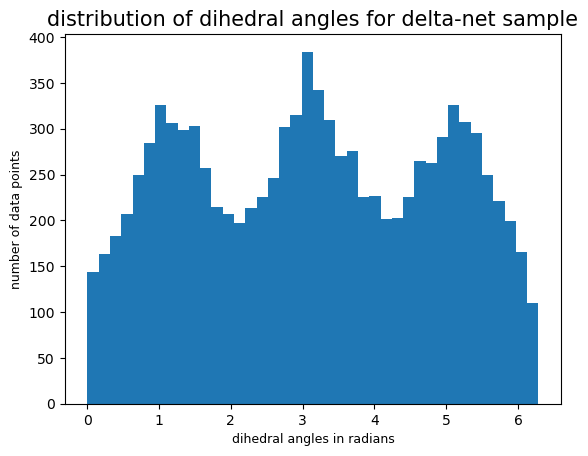

In [6]:
plt.hist(dihedrals, 40) 
plt.title("distribution of dihedral angles for delta-net sample", fontsize = 15)
plt.xlabel("dihedral angles in radians", fontsize = 9)
plt.ylabel("number of data points", fontsize = 9)
plt.savefig("dihedral_dist_metad.pdf")

# Recenter central bond

In [7]:
def recenter_bond(x):
    x = x.reshape((4,3))
    assert x.shape == (4,3)
    recentered_x = x - x[0,:]
    theta = np.arctan2(recentered_x[1,1], recentered_x[1,0])
    xy_rotated = np.array([[np.cos(-theta), -np.sin(-theta), 0],[np.sin(-theta), np.cos(-theta), 0], [0, 0, 1]])@recentered_x.T
    xy_rotated = xy_rotated.T
    phi = np.arctan2(xy_rotated[1,2], xy_rotated[1,0])
    zx_rotated = np.array([[np.cos(-phi),0, -np.sin(-phi)],[0, 1, 0], [np.sin(-phi), 0, np.cos(-phi)]])@xy_rotated.T
    zx_rotated = zx_rotated.T
    return zx_rotated.flatten()

In [8]:
def recenter_bond_torch(x):
    x = x.reshape((4,3))
    assert x.shape == (4,3)
    recentered_x = x - x[1,:]
    theta = np.arctan2(recentered_x[2,1], recentered_x[2,0])
    xy_rotated = np.array([[np.cos(-theta), -np.sin(-theta), 0],[np.sin(-theta), np.cos(-theta), 0], [0, 0, 1]])@recentered_x.T
    xy_rotated = xy_rotated.T
    phi = np.arctan2(xy_rotated[2,2], xy_rotated[2,0])
    zx_rotated = np.array([[np.cos(-phi),0, -np.sin(-phi)],[0, 1, 0], [np.sin(-phi), 0, np.cos(-phi)]])@xy_rotated.T
    zx_rotated = zx_rotated.T
    return zx_rotated.flatten()

In [9]:
def dihedral_angle_torch(x):
    # assert x.shape == torch.Size([14,3])
    # carbons = x[mask,:]
    carbons = x
    vectors = carbons[1:,:] - carbons[:-1,:]
    na = torch.cross(-vectors[0,:], vectors[1,:])
    nb = torch.cross(-vectors[1,:], vectors[2,:])
    xx = torch.dot(na, nb)
    xp = torch.cross(na,nb)
    yy = torch.dot(vectors[1,:].T,xp)/torch.norm(vectors[1,:])
    angle = torch.atan2(yy,xx)
    return angle

In [9]:
data = np.apply_along_axis(recenter_bond_torch, 1, data)

# Compute PCA

In [56]:
import sklearn
kpca = sklearn.decomposition.KernelPCA(n_components=4)
kpca.fit(data.T)
transformed_data = kpca.fit_transform(data.T)

In [57]:
kpca.eigenvectors_.shape

(12, 4)

In [58]:
transformed_data = data@kpca.eigenvectors_

In [59]:
size_vec = np.pi - np.abs(dihedrals - np.pi)
dihedrals_vec = np.abs(dihedrals - np.pi)

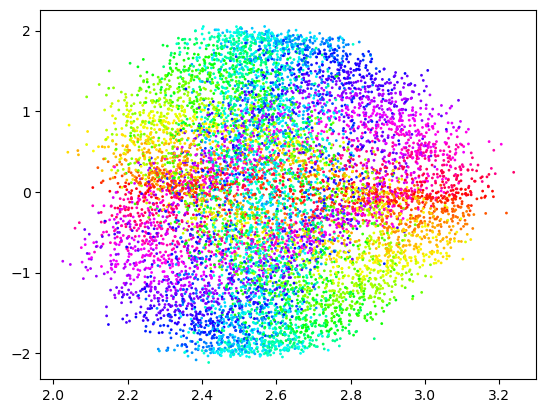

In [61]:
plt.scatter(transformed_data[:,0], transformed_data[:,2], c=dihedrals, cmap='hsv', s=1.0)

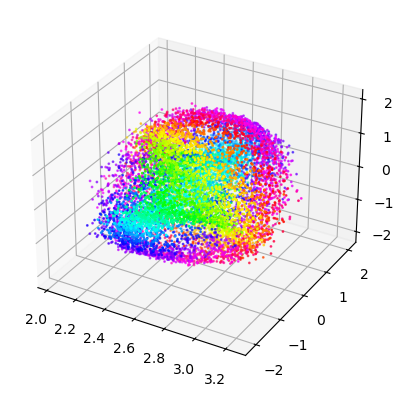

In [62]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(transformed_data[:,0], transformed_data[:,2], transformed_data[:,3], c=dihedrals, cmap='hsv',s=1.0)

(array([ 24.,  98., 126., 139., 153., 162., 187., 162., 177., 153., 191.,
        156., 176., 155., 169., 169., 197., 202., 241., 223., 262., 307.,
        296., 441., 472., 535., 414., 362., 256., 234., 250., 232., 179.,
        200., 177., 172., 166., 151., 176., 168., 151., 161., 149., 165.,
        134., 151., 154., 128.,  77.,  20.]),
 array([-1.99091234, -1.91060256, -1.83029277, -1.74998299, -1.6696732 ,
        -1.58936342, -1.50905363, -1.42874385, -1.34843406, -1.26812428,
        -1.18781449, -1.10750471, -1.02719492, -0.94688514, -0.86657535,
        -0.78626557, -0.70595578, -0.625646  , -0.54533621, -0.46502643,
        -0.38471664, -0.30440686, -0.22409707, -0.14378729, -0.0634775 ,
         0.01683228,  0.09714207,  0.17745185,  0.25776164,  0.33807142,
         0.41838121,  0.49869099,  0.57900078,  0.65931056,  0.73962035,
         0.81993013,  0.90023992,  0.9805497 ,  1.06085949,  1.14116927,
         1.22147906,  1.30178885,  1.38209863,  1.46240842,  1.5427182 ,
 

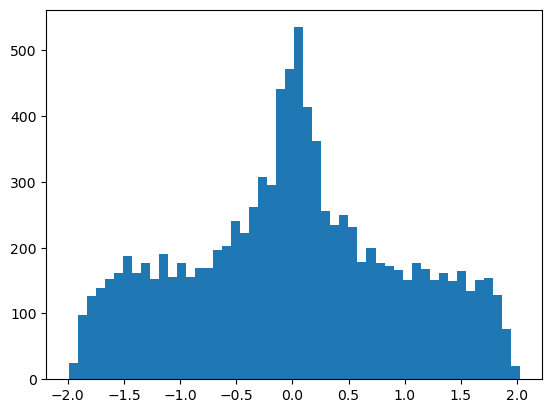

In [16]:
plt.hist(transformed_data[:,2], bins=50)

## Compute TMD map

In [17]:
data.shape

(10000, 12)

In [18]:
target_measure_manifold = np.ones(data.shape[0])

In [19]:
n_neighbors = 8192
# use epsilon = 100.0 for all atom
# use epsilon = 50.0 for carbons only
print("sparse dmaps!")
[stationary, K, L] = create_laplacian_sparse(data, \
                                             target_measure_manifold, \
                                             epsilon=50.0,\
                                             n_neighbors=n_neighbors)

sparse dmaps!
Data type of squared distance matrix: <class 'scipy.sparse._csr.csr_matrix'>
Ratio of nonzeros to zeros in kernel matrix: 0.83126342


In [20]:
diffcoords, eigvecs, eigvals = compute_spectrum_sparse(L, stationary, num_eigvecs=10)

Text(0.5, 1.0, 'Decay of eigenvalues of transition matrix $P = (I + \\epsilon L)$')

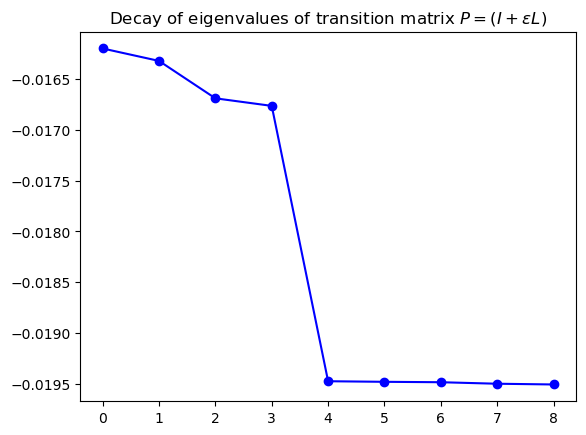

In [21]:
plt.plot(eigvals, 'bo-')
plt.title(f"Decay of eigenvalues of transition matrix $P = (I + \epsilon L)$")

## Load tmdmap

In [22]:
size_vec = np.pi - np.abs(dihedrals - np.pi)
dihedrals_vec = np.abs(dihedrals - np.pi)

In [23]:
dihedrals_vec.shape

(10000,)

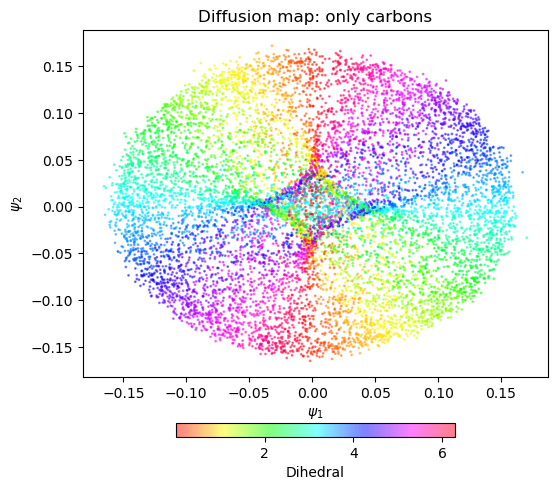

In [30]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(diffcoords[:, 1], diffcoords[:, 2], \
               c=dihedrals, cmap='hsv', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

(array([ 12.,  66., 114., 139., 121., 155., 176., 185., 164., 192., 178.,
        202., 193., 188., 160., 202., 225., 246., 239., 257., 259., 295.,
        352., 442., 487., 445., 379., 333., 228., 278., 221., 233., 220.,
        200., 196., 168., 189., 197., 157., 171., 164., 153., 157., 132.,
        149., 129., 130.,  83.,  33.,   6.]),
 array([-0.16459081, -0.15786633, -0.15114185, -0.14441737, -0.13769288,
        -0.1309684 , -0.12424392, -0.11751944, -0.11079495, -0.10407047,
        -0.09734599, -0.09062151, -0.08389702, -0.07717254, -0.07044806,
        -0.06372358, -0.0569991 , -0.05027461, -0.04355013, -0.03682565,
        -0.03010117, -0.02337668, -0.0166522 , -0.00992772, -0.00320324,
         0.00352125,  0.01024573,  0.01697021,  0.02369469,  0.03041917,
         0.03714366,  0.04386814,  0.05059262,  0.0573171 ,  0.06404159,
         0.07076607,  0.07749055,  0.08421503,  0.09093952,  0.097664  ,
         0.10438848,  0.11111296,  0.11783744,  0.12456193,  0.13128641,
 

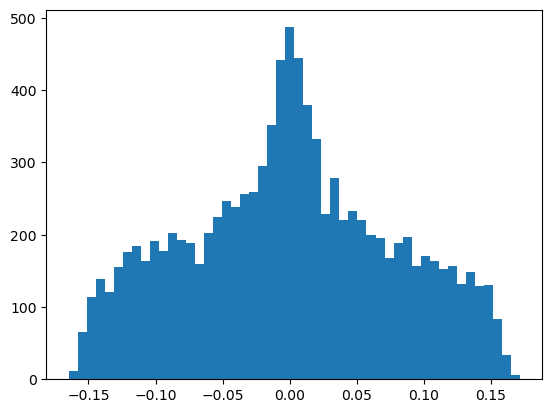

In [33]:
plt.hist(diffcoords[:,2], bins=50)

In [101]:
azim = ax.azim
roll = ax.roll
elev = ax.elev

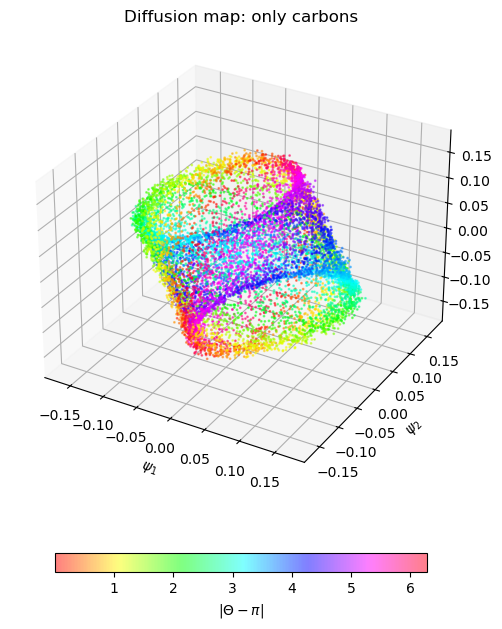

In [35]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(diffcoords[:,0], diffcoords[:, 2], diffcoords[:,3], \
               c=dihedrals, cmap='hsv', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label=f'$|\Theta - \pi|$')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
# ax.view_init(azim=azim-160, elev=elev, roll=roll)
plt.show()

In [100]:
ax.roll

0

In [26]:
r = eigvecs[:,0]**2 + eigvecs[:,1]**2

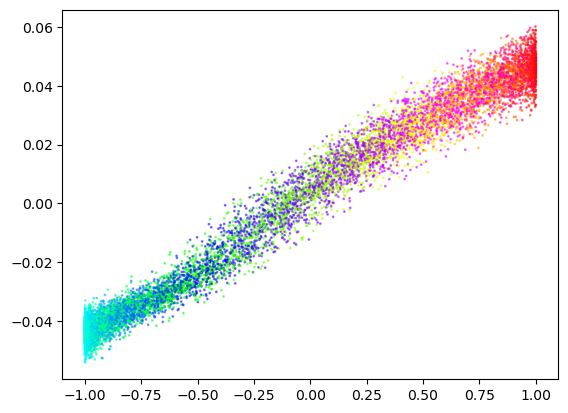

In [33]:
plt.scatter(np.cos(dihedrals), diffcoords[:,2], c=dihedrals, s=1.0,alpha=0.5, cmap='hsv')

In [29]:
np.savez("tmdmap_carbons_recentered12_alphazero_sep29_2024.npz", diffcoords=diffcoords, L=L.toarray(), eigvals=np.diag(eigvals))

In [82]:
diffcoords = np.load("tmdmap_carbons_alphazero_jul3_2024.npz")
diffcoords = diffcoords['arr_0']

FileNotFoundError: [Errno 2] No such file or directory: 'tmdmap_carbons_alphazero_jul3_2024.npz'